In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

# drive.mount('/content/drive')

# file_path = '/content/drive/MyDrive/healthcare_dataset.csv'

file_path = "healthcare_ds.csv"
df = pd.read_csv(file_path)

# Display the shape of the data and first few rows
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


Drop unnecessary columns (Name, Doctor, Hospital), encode categorical variables, and handle missing data

In [2]:
# Drop columns that are not needed for ML models
df_cleaned = df.drop(['Name', 'Doctor', 'Hospital'], axis=1)

# Convert date columns to datetime and create "Length of Stay"
df_cleaned['Date of Admission'] = pd.to_datetime(df_cleaned['Date of Admission'])
df_cleaned['Discharge Date'] = pd.to_datetime(df_cleaned['Discharge Date'])
df_cleaned['Length of Stay'] = (df_cleaned['Discharge Date'] - df_cleaned['Date of Admission']).dt.days

# Handle missing values (e.g., replace NaN with mean or mode)
df_cleaned['Billing Amount'].fillna(df_cleaned['Billing Amount'].mean(), inplace=True)
df_cleaned['Medication'].fillna('Unknown', inplace=True)
df_cleaned['Test Results'].fillna('Unknown', inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()

# Encode 'Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Test Results'
df_cleaned['Gender'] = label_encoder.fit_transform(df_cleaned['Gender'])
df_cleaned['Blood Type'] = label_encoder.fit_transform(df_cleaned['Blood Type'])
df_cleaned['Medical Condition'] = label_encoder.fit_transform(df_cleaned['Medical Condition'])
df_cleaned['Admission Type'] = label_encoder.fit_transform(df_cleaned['Admission Type'])
df_cleaned['Test Results'] = label_encoder.fit_transform(df_cleaned['Test Results'])

# Display first few rows after preprocessing
df_cleaned.head()


C:\Users\roshan\AppData\Local\Temp\ipykernel_5480\2971295002.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Billing Amount'].fillna(df_cleaned['Billing Amount'].mean(), inplace=True)
C:\Users\roshan\AppData\Local\Temp\ipykernel_5480\2971295002.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Length of Stay
0,30,1,5,2,2024-01-31,Blue Cross,18856.281306,328,2,2024-02-02,Paracetamol,2,2
1,62,1,0,5,2019-08-20,Medicare,33643.327287,265,1,2019-08-26,Ibuprofen,1,6
2,76,0,1,5,2022-09-22,Aetna,27955.096079,205,1,2022-10-07,Aspirin,2,15
3,28,0,6,3,2020-11-18,Medicare,37909.782410,450,0,2020-12-18,Ibuprofen,0,30
4,43,0,2,2,2022-09-19,Aetna,14238.317814,458,2,2022-10-09,Penicillin,0,20


In [3]:
# Predict 'Medical Condition' using Random Forest Classifier

# Features (X) and Target (y)
X = df_cleaned.drop(['Medical Condition'], axis=1)
y = df_cleaned['Medical Condition']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Convert 'Date of Admission' and 'Discharge Date' to numerical features
X_train['Date of Admission'] = X_train['Date of Admission'].dt.dayofyear
X_train['Discharge Date'] = X_train['Discharge Date'].dt.dayofyear

X_test['Date of Admission'] = X_test['Date of Admission'].dt.dayofyear
X_test['Discharge Date'] = X_test['Discharge Date'].dt.dayofyear

# Convert 'Insurance Provider' and 'Medication' to numerical using Label Encoding
# Create a LabelEncoder instance
insurance_encoder = LabelEncoder()
medication_encoder = LabelEncoder() # Create a new encoder for 'Medication'

# Fit and transform on training data
X_train['Insurance Provider'] = insurance_encoder.fit_transform(X_train['Insurance Provider'])
X_train['Medication'] = medication_encoder.fit_transform(X_train['Medication']) # Encode 'Medication'

# Transform test data using the same encoders
X_test['Insurance Provider'] = insurance_encoder.transform(X_test['Insurance Provider'])
X_test['Medication'] = medication_encoder.transform(X_test['Medication'])  # Encode 'Medication'


# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.291981981981982
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.30      0.30      1915
           1       0.29      0.30      0.29      1847
           2       0.28      0.29      0.29      1871
           3       0.29      0.29      0.29      1822
           4       0.29      0.28      0.28      1788
           5       0.32      0.29      0.30      1857

    accuracy                           0.29     11100
   macro avg       0.29      0.29      0.29     11100
weighted avg       0.29      0.29      0.29     11100



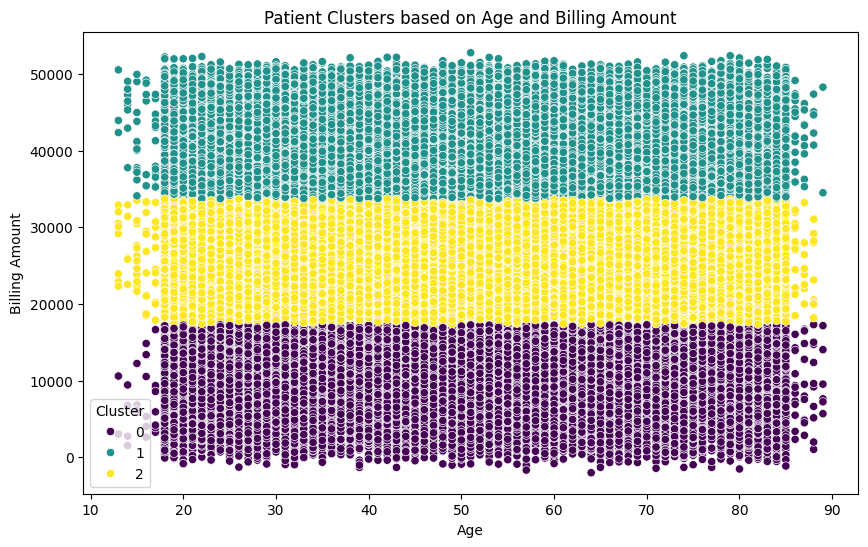

In [4]:
# Use KMeans clustering to segment patients into clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Instead of converting 'Date of Admission' and 'Discharge Date' again,
# create a copy of df_cleaned with the necessary preprocessing for KMeans
# Exclude 'Cluster' from drop as it doesn't exist yet. It will be created later
X_kmeans = df_cleaned.drop(['Medical Condition'], axis=1)

# Convert 'Date of Admission' and 'Discharge Date' to numerical features
X_kmeans['Date of Admission'] = X_kmeans['Date of Admission'].dt.dayofyear
X_kmeans['Discharge Date'] = X_kmeans['Discharge Date'].dt.dayofyear

# Convert 'Insurance Provider' and 'Medication' to numerical using Label Encoding
# Create a LabelEncoder instance for 'Insurance Provider'
insurance_encoder = LabelEncoder()
# Create a LabelEncoder instance for 'Medication'
medication_encoder = LabelEncoder()

# Fit and transform on X_kmeans
X_kmeans['Insurance Provider'] = insurance_encoder.fit_transform(X_kmeans['Insurance Provider'])
X_kmeans['Medication'] = medication_encoder.fit_transform(X_kmeans['Medication'])

# Fit the KMeans model
df_cleaned['Cluster'] = kmeans.fit_predict(X_kmeans)

# Visualize clusters using Age and Billing Amount
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='Billing Amount', hue='Cluster', data=df_cleaned, palette='viridis')
plt.title('Patient Clusters based on Age and Billing Amount')
plt.show()

Step 5: Resource Forecasting (Time-Series Analysis)

We'll use ARIMA to forecast hospital resource demand (e.g., room occupancy).

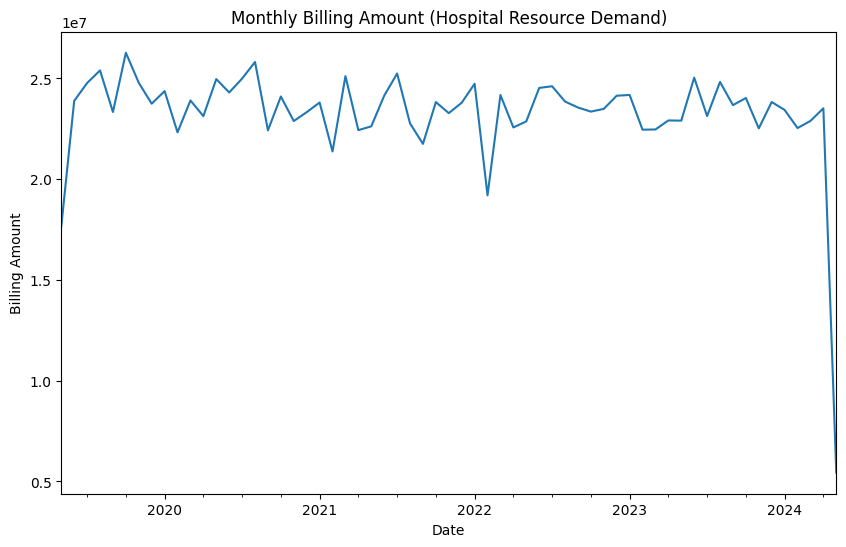

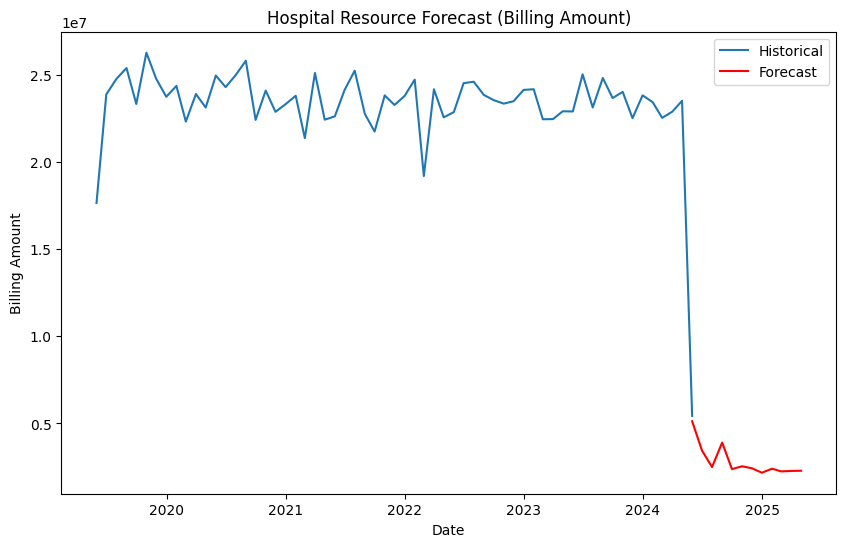

: 

In [ ]:
# Forecasting: Use 'Length of Stay' and 'Billing Amount' for time-series prediction

# Resample the data by month for hospital resource demand prediction
df_cleaned['Date of Admission'] = pd.to_datetime(df_cleaned['Date of Admission'])
df_monthly = df_cleaned.resample('ME', on='Date of Admission').agg({'Billing Amount': 'sum'})

# Plot the total billing amount over time (as an indicator of hospital resource use)
plt.figure(figsize=(10,6))
df_monthly['Billing Amount'].plot()
plt.title('Monthly Billing Amount (Hospital Resource Demand)')
plt.xlabel('Date')
plt.ylabel('Billing Amount')
plt.show()

# Fit ARIMA model (order may need tuning based on data characteristics)
arima_model = ARIMA(df_monthly['Billing Amount'], order=(5, 1, 0))  # Example order
arima_fit = arima_model.fit()

# Forecast next 12 months
forecast = arima_fit.forecast(steps=12)
forecast_index = pd.date_range(df_monthly.index[-1], periods=12, freq='ME')

# Plot forecast
plt.figure(figsize=(10,6))
plt.plot(df_monthly.index, df_monthly['Billing Amount'], label='Historical')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Hospital Resource Forecast (Billing Amount)')
plt.xlabel('Date')
plt.ylabel('Billing Amount')
plt.legend()
plt.show()


Step 7: Model Explainability with SHAP
For interpretability, SHAP (Shapley Additive Explanations) helps us understand how each feature contributes to the model's predictions. We'll focus on the RandomForestClassifier.

For interpretability, SHAP (Shapley Additive Explanations) helps us understand how each feature contributes to the model's predictions. We'll focus on the RandomForestClassifier.

In [ ]:
import shap

# Sample a smaller subset of the test data for SHAP calculation
X_sample = X_test.sample(n=200, random_state=42)  # Using a random sample of 200 instances

# Create a faster explainer object
explainer = shap.Explainer(rf_classifier, X_train)

# Calculate SHAP values for the smaller sample
shap_values = explainer(X_sample)

# Plot summary plot to visualize feature importance
shap.plots.bar(shap_values)

Step 8: Hyperparameter Tuning for RandomForestClassifier

You can further improve the Random Forest Classifier by tuning the hyperparameters using GridSearchCV.

Step 9: Final Model Evaluation

After tuning the model, you should assess the performance again using different metrics and analyze the results. For instance, you can use Confusion Matrix to see how well the model performs.